In [111]:
import sys
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
import re
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumRings


from copy import deepcopy


def remove_atom_mapping_from_reaction_smiles(reaction_smiles):
    """
    Remove atom mapping from a reaction SMILES string.
    
    Parameters:
    - reaction_smiles (str): A reaction SMILES string with atom mapping.
    
    Returns:
    - str: A reaction SMILES string without atom mapping.
    """
    # Split the reaction SMILES into its components (reactants, agents, products)
    parts = reaction_smiles.split('>>')
    
    # Remove atom mapping from each part
    cleaned_parts = [Chem.CanonSmiles(re.sub(r":\d+", "", part)) for part in parts]
    
    # Concatenate the cleaned parts back into a reaction SMILES string
    cleaned_reaction_smiles = '>>'.join(cleaned_parts)
    
    return cleaned_reaction_smiles



def calculate_chemical_properties(dictionary_list):
    updated_list = deepcopy(dictionary_list)  # Create a deep copy of the original list
    for entry in updated_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']

        # Initialize RDKit molecule objects from SMILES
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)

        if reactant_mol is not None and product_mol is not None:
            # Calculate carbon difference
            num_carbon_reactants = sum([atom.GetAtomicNum() == 6 for atom in reactant_mol.GetAtoms()])
            num_carbon_products = sum([atom.GetAtomicNum() == 6 for atom in product_mol.GetAtoms()])
            entry['carbon_difference'] = abs(num_carbon_reactants - num_carbon_products)
            
            # Calculate total number of carbons
            entry['total_carbons'] = num_carbon_reactants + num_carbon_products

            # Calculate total number of bonds
            entry['total_bonds'] = abs(reactant_mol.GetNumBonds() - product_mol.GetNumBonds())

            # Calculate total number of rings
            entry['total_rings'] = abs(CalcNumRings(reactant_mol) - CalcNumRings(product_mol))
        else:
            entry['carbon_difference'] = "Invalid SMILES"
            entry['total_carbons'] = "Invalid SMILES"
            entry['total_bonds'] = "Invalid SMILES"
            entry['total_rings'] = "Invalid SMILES"



        # Process for fragment count calculation
        reactant_fragment_count = len(reactant_smiles.split('.'))
        product_fragment_count = len(product_smiles.split('.'))
        total_fragment_count = reactant_fragment_count + product_fragment_count
        entry['fragment_count'] = total_fragment_count

    return updated_list




def count_boundary_atoms_products_and_calculate_changes(list_of_dicts):
    for item in list_of_dicts:
        count = 0  # Initialize count for boundary_atoms_products
        # Initialize variables for bond and ring changes
        bond_change = 0
        ring_change = 0
        
        if 'boundary_atoms_products' in item and item['boundary_atoms_products']:
            for i in item['boundary_atoms_products']:
                if isinstance(i, dict):
                    count += 1
                elif isinstance(i, list):
                    for j in i:
                        if isinstance(j, dict):
                            count += 1
        
        # Split new_reactions into reactant and product SMILES and calculate changes
        
        reactant_product = item['new_reaction'].split('>>')
        if len(reactant_product) == 2:  # Ensure there are both reactant and product
            reactant_smiles, product_smiles = reactant_product
            reactant_mol = Chem.MolFromSmiles(reactant_smiles)
            product_mol = Chem.MolFromSmiles(product_smiles)
            
            if reactant_mol and product_mol:
                # Calculate bond change
                bond_change = abs(reactant_mol.GetNumBonds() - product_mol.GetNumBonds())
                # Calculate ring change
                ring_change = abs(CalcNumRings(reactant_mol) - CalcNumRings(product_mol))
        
        # Add calculated values to the dictionary
        item['num_boundary'] = count
        item['bond_change_merge'] = bond_change
        item['ring_change_merge'] = ring_change

    return list_of_dicts

# Merge mol MCS

In [3]:
import pandas as pd
from SynRBL.rsmi_utils import load_database
from IPython.display import clear_output

data_name = 'USPTO_unbalance_class'
data = pd.read_csv(f'../../../Pipeline/Validation/Analysis/SynRBL - {data_name}.csv').drop(['Note'], axis=1)
data.loc[data['Result'] == 'CONSIDER', 'Result']=False

merge_data = load_database(f'../../../Data/Validation_set/{data_name}/MCS/MCS_Impute.json.gz')
mcs_data = load_database(f'../../../Data/Validation_set/{data_name}/mcs_based_reactions.json.gz')
mcs_data = calculate_chemical_properties(mcs_data)
clear_output(wait=False)
mcs_data[0]

{'id': 'US20110306609A1',
 'class': 6,
 'reactions': 'CCOC(=O)c1nc(-c2ccccc2)cs1>>O=C(O)c1nc(-c2ccccc2)cs1',
 'reactants': 'CCOC(=O)c1nc(-c2ccccc2)cs1',
 'products': 'O=C(O)c1nc(-c2ccccc2)cs1',
 'R-id': 'USPTO_unbalance_class_0',
 'carbon_balance_check': 'products',
 'carbon_difference': 2,
 'total_carbons': 22,
 'total_bonds': 2,
 'total_rings': 0,
 'fragment_count': 2}

In [98]:
import pandas as pd

def process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=True):
    """
    Processes and combines datasets from specified paths.

    Parameters:
    - list_data (list): List of dataset names.
    - pipeline_path (str): Path to the pipeline files.
    - data_path (str): Path to the data files.

    Returns:
    - pd.DataFrame: Combined DataFrame of all processed datasets.
    """
    data_all = pd.DataFrame()
    
    for data_name in list_data:
        # Load dataset CSV and adjust columns
        data_csv_path = f'{pipeline_path}/Validation/Analysis/SynRBL - {data_name}.csv'
        data = pd.read_csv(data_csv_path).drop(['Note'], axis=1)
        #print(data.shape)
        data.loc[data['Result'] == 'CONSIDER', 'Result'] = False
        data.loc[data['Result'] == 'FALSE', 'Result'] = False
        data.loc[data['Result'] == 'TRUE', 'Result'] = True
        #data['Result'] =

        # Load and process additional data
        merge_data_path = f'{data_path}/Validation_set/{data_name}/MCS/MCS_Impute.json.gz'
        mcs_data_path = f'{data_path}/Validation_set/{data_name}/mcs_based_reactions.json.gz'
        
        merge_data = load_database(merge_data_path)
        #print(len(merge_data))
        merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
        mcs_data = load_database(mcs_data_path)
        id = [value['R-id'] for value in merge_data]
        mcs_data = [value for value in mcs_data if value['R-id'] in id]
        mcs_data = calculate_chemical_properties(mcs_data)
        #print(len(mcs_data))
        #clear_output(wait=False)
        
        # Combine data
        combined_data = pd.concat([
            pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
            data,
            pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge']],
        ], axis=1)
        #print(combined_data.isnull().sum().sum())
        combined_data.loc[(combined_data['mcs_carbon_balanced'] == False) & (combined_data['Result'] == True), 'Result']=False
        if remove_undetected:
            combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
        
        data_all = pd.concat([data_all, combined_data], axis=0)
    data_all = data_all.reset_index(drop=True)
    unnamed_columns = [col for col in data_all.columns if 'Unnamed' in col]
    data_all = data_all.drop(unnamed_columns, axis=1)

    return data_all


list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'

data_total = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=True)


[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not removing hydrogen atom without neighbors
[21:30:40] WARNING: not r

In [14]:
data_total.shape

(2255, 14)

In [448]:
# def bin_value(value, bin_size=10):
#     """
#     Bin a value into groups of 10 or a specified bin size.

#     Parameters:
#     - value (int or float): The value to bin.
#     - bin_size (int): Size of each bin. Default is 10.

#     Returns:
#     - int: The binned value representing the lower bound of the bin.
#     """
#     binned_value = (value // bin_size) * bin_size
#     return binned_value

# # Example usage:
# data_all['carbons_count'] = data_all['total_carbons'].apply(lambda x: bin_value(x, bin_size=20))
# data_all['bonds_count'] = data_all['total_bonds'].apply(lambda x: bin_value(x, bin_size=5))

In [132]:
def standardize_columns(data):
    data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
    data.loc[data['fragment_count']>8, 'fragment_count'] = '> 8'
    data.loc[data['Bond Changes']>5, 'Bond Changes'] = '> 5'
    data.loc[data['bond_change_merge']>3, 'bond_change_merge'] = '> 3'
    #data.loc[data['ring_change_merge']>10, 'ring_change_merge'] = 11
    data.loc[data['num_boundary']>4, 'num_boundary'] = '> 4'
    #data.loc[data['total_carbons']>5, 'total_carbons'] = 6
    #data.loc[data['total_rings']>10, 'total_rings'] = 11
    data['reactions'] = data['reactions'].apply(lambda x: remove_atom_mapping_from_reaction_smiles(x))
    data = data.drop_duplicates(subset=['reactions'])
    data['Result'] = data['Result'].astype('bool')
    return data

In [133]:
data_all = standardize_columns(data_total)

data_all.shape

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_46705/3953394590.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_46705/3953394590.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['fragment_count']>8, 'fragment_count'] = '> 8'
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_46705/3953394590.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 5' has dtype incompatible with int64, please explicitly cast to a compatible dt

(1954, 14)

## EDA

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import matplotlib.colors as mcolors

class AccuracyVisualizer:
    """
    A class for visualizing accuracy metrics and confidence intervals of datasets across different categories, 
    with support for line and bar charts, including error bars for confidence intervals. It dynamically adjusts
    subplot arrangements based on the number of metrics provided, allowing for a comprehensive and customizable 
    visualization experience.

    Attributes
    ----------
    df : pd.DataFrame
        The dataset containing accuracy results and other metrics for visualization. It must contain a 'Result' column
        used for calculating accuracy and confidence intervals.
    columns : list of str
        Column names in the dataframe that represent different categories or groups for which accuracy and confidence 
        intervals will be visualized.
    titles : list of str
        Custom titles for each subplot corresponding to the columns being visualized. These titles are used as x-axis
        labels for each chart.

    Methods
    -------
    calculate_accuracy_and_confidence(column):
        Calculates the accuracy and Wilson confidence intervals for a given column in the dataframe.

    visualize_accuracy(error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False, show_values=False, savepath=None):
        Generates visualizations for the accuracy metrics specified in the columns attribute, with optional error bars,
        supporting both line and bar chart types.
    """
    def __init__(self, df, columns, titles):
        """
        Initializes the AccuracyVisualizer with a dataframe, columns for visualization, and titles.

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to visualize, containing at least one column for grouping and a 'Result' column for accuracy calculations.
        columns : list of str
            The columns in the dataset that should be visualized, representing different categories or groups.
        titles : list of str
            Titles for the subplots corresponding to each column, used as x-axis labels.
        """
        assert len(columns) == len(titles), "Columns and titles must have the same length"
        self.df = df
        self.columns = columns
        self.titles = titles

    def calculate_accuracy_and_confidence(self, column):
        """
        Calculates the accuracy and confidence intervals for a given column in the dataframe.

        This method groups the dataset by the specified column, calculates the sum and size for each group, determines
        the accuracy as the ratio of sum to size, and computes the confidence intervals using the Wilson method.

        Parameters
        ----------
        column : str
            The column for which to calculate accuracy and confidence intervals.

        Returns
        -------
        pd.DataFrame
            A dataframe with the specified column, accuracy, and confidence intervals (lower and upper bounds) for each group.
        """

        group_data = self.df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        group_data = group_data[group_data['Accuracy'] > 0]

        confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
        group_data['lower'] = group_data['Accuracy'] - confidence_lower
        group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    def visualize_accuracy(self, error_bar=True, chart_type='line', error_bar_color='black', 
                           same_color_scale=False, show_values=False, savepath=None):
        """
        Generates a visualization of the accuracy metrics specified in the columns attribute.

        This method supports dynamic adjustment of subplot layouts based on the number of metrics, optional error bars,
        and the choice between line and bar charts. It allows for a unified or varying color scale across subplots and
        the option to display numerical values on the charts.

        Parameters
        ----------
        error_bar : bool, optional
            Whether to include error bars for confidence intervals in the charts (default is True).
        chart_type : {'line', 'bar'}, optional
            The type of chart to use for visualization ('line' or 'bar', default is 'line').
        error_bar_color : str, optional
            Color for the error bars, if error_bar is True (default is 'black').
        same_color_scale : bool, optional
            Whether to use the same color scale across all subplots based on the maximum 'size' value in the dataset
            (default is False, which uses individual scales per subplot).
        show_values : bool, optional
            Whether to display numerical values on the charts (default is False).
        savepath : str or None, optional
            Path to save the figure. If None, the figure is not saved (default is None).

        Returns
        -------
        None
        """
        n_metrics = len(self.columns)
        if n_metrics == 1:
            nrows, ncols = 1, 1
        elif n_metrics == 2:
            nrows, ncols = 2, 1
        elif n_metrics == 3:
            nrows, ncols = 3, 1
        elif n_metrics == 4:
            nrows, ncols = 2, 2
        elif n_metrics in [5, 6]:
            nrows, ncols = 3, 2
        else:
            nrows, ncols = (n_metrics + 2) // 3, 3

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15*ncols, 8*nrows), squeeze=False)
        cmap = plt.get_cmap('flare', 256)

        for i, (column, title) in enumerate(zip(self.columns, self.titles)):
            ax = axes.flatten()[i]
            data = self.calculate_accuracy_and_confidence(column)

            norm = plt.Normalize(vmin=0, vmax=data['size'].max()) if not same_color_scale else plt.Normalize(vmin=0, vmax=self.df['size'].max())
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            colors = [mcolors.to_rgba(cmap(norm(s))) for s in data['size']]

            if chart_type == 'line':
                sns.lineplot(data=data, x=column, y='Accuracy', marker='o', ax=ax, palette=colors)
                if error_bar:
                    ax.errorbar(data[column], data['Accuracy'], yerr=[data['lower'], data['upper']], fmt='o', capsize=5, ecolor=error_bar_color)
            elif chart_type == 'bar':
                sns.barplot(data=data, x=column, y='Accuracy', palette=colors, ax=ax)
                ax.set_ylim(0, 1)
                if error_bar:
                    x_positions = np.arange(len(data[column]))
                    ax.errorbar(x=x_positions, y=data['Accuracy'], yerr=[data['lower'].values, data['upper'].values], fmt='none', capsize=5, ecolor=error_bar_color)
                if show_values:
                    for bar in ax.patches:
                        ax.annotate(format(bar.get_height(), '.2f'), 
                                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                    ha='center', va='bottom', 
                                    xytext=(0, 5), textcoords='offset points', fontsize=24)

            ax.set_xlabel(title, fontsize=32, weight='bold', labelpad=20)
            ax.set_ylabel('Accuracy', fontsize=28)

            # Bring x-axis ticks and labels to the top
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('bottom')  # Set the x-axis label position to top

            # Adjust tick parameters for better visibility
            ax.tick_params(axis='x', which='major', labelsize=24, direction='out', length=6, width=2, pad=5)
            ax.tick_params(axis='y', which='major', labelsize=24, direction='out', length=6, width=2)

            plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10).ax.set_ylabel('Number of Samples', size=24)

        plt.tight_layout()
        if savepath:
            plt.savefig(savepath)
        plt.show()


/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_46705/4230345718.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=column, y='Accuracy', palette=colors, ax=ax)
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_46705/4230345718.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=column, y='Accuracy', palette=colors, ax=ax)
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_46705/4230345718.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=column, y='Accuracy', palett

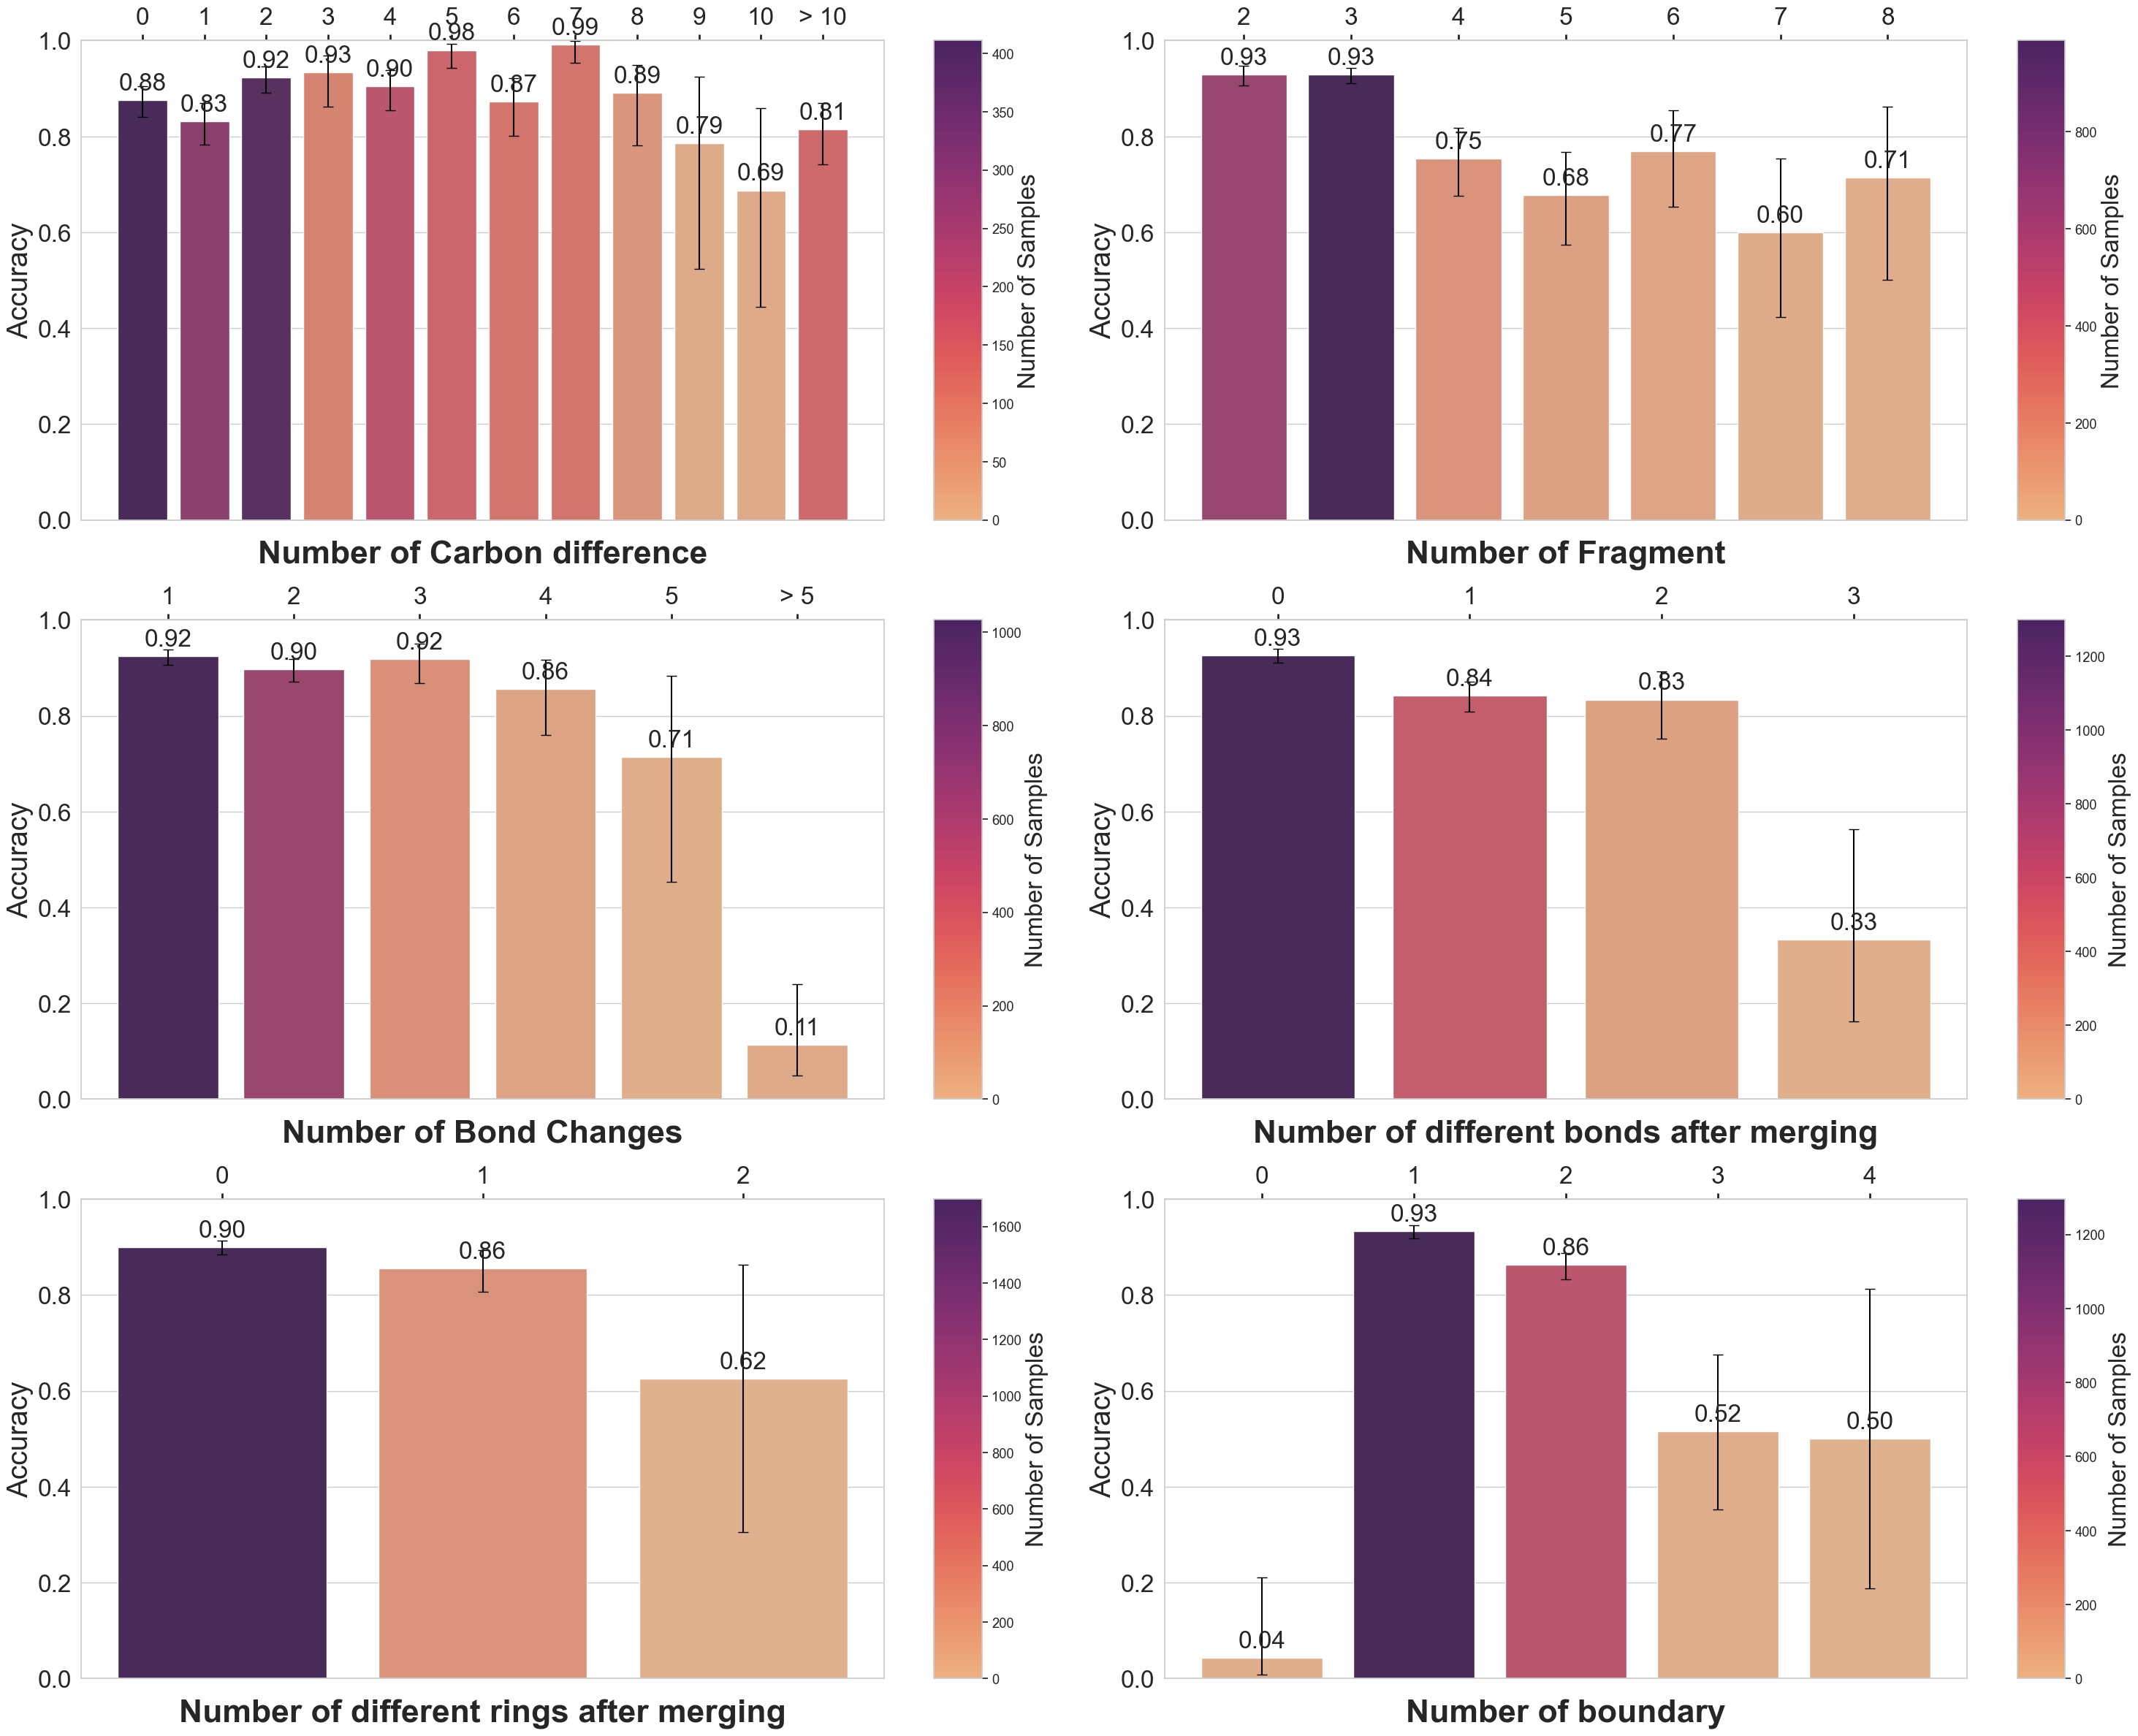

In [136]:
columns = ['carbon_difference', 'fragment_count', 'Bond Changes', 'bond_change_merge', 'ring_change_merge', 'num_boundary']
titles = ['Number of Carbon difference', 'Number of Fragment', 'Number of Bond Changes', 'Number of different bonds after merging', 
          'Number of different rings after merging', 'Number of boundary']
visualizer = AccuracyVisualizer(data_all, columns, titles)
visualizer.visualize_accuracy(chart_type='bar', show_values=True, error_bar=True, savepath=None)

## Feature importance

In [126]:
data_check = data_total.drop(['R-id', 'Index', 'reactions', 'mcs_carbon_balanced'], axis=1)

In [140]:
data_check.columns

Index(['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'Result', 'Bond Changes', 'num_boundary',
       'ring_change_merge', 'bond_change_merge'],
      dtype='object')

In [221]:
import pandas as pd
import xgboost as xgb
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


class Visualization:
    def __init__(self, data, target_col, cols_for_contour):
        self.data = data
        self.target_col = target_col
        self.cols_for_contour = cols_for_contour

    def feature_importance(self, ax):
        X = self.data.drop(self.target_col, axis=1)
        y = self.data[self.target_col]

        clf = xgb.XGBClassifier(random_state=42)
        clf.fit(X, y)

        feature_importances = clf.feature_importances_
        importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        cmap = plt.get_cmap('flare')
        colors = [cmap(i / len(importance_df)) for i in range(len(importance_df))]
        bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)

        for bar, val in zip(bars, importance_df['Importance']):
            ax.text(val + 0.005, bar.get_y() + bar.get_height() / 2, f'{val:.3f}', va='center', fontsize=10, color='black')

        ax.set_xlabel('Importance', fontsize=20)
        #ax.set_title('Feature Importance (XGBoost)', fontsize=32, weight='bold', pad=20)
        ax.invert_yaxis()

    def contour_plot(self, features, ax):
        df = deepcopy(self.data)
        le = LabelEncoder()
        df['Outcome'] = le.fit_transform(df[self.target_col])

        X = df[list(features)]
        y = df['Outcome']

        model = XGBClassifier(random_state=42)
        model.fit(X, y)

        x_min, x_max = X[features[0]].min() - 1, X[features[0]].max() + 1
        y_min, y_max = X[features[1]].min() - 1, X[features[1]].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))  # Increase the number of points

        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)

        # Create filled contour plot with increased size
        contour = ax.contourf(xx, yy, Z, alpha=0.8, levels=np.linspace(0, 1, 11), cmap=plt.cm.coolwarm)

        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])

        # Add colorbar for the probability values
        cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='Probability')


    def visualize(self):
        fig = plt.figure(figsize=(16, 12))
        gs = gridspec.GridSpec(3, 3, figure=fig)
        
        # Feature importance plot (A)
        ax_feature_importance = fig.add_subplot(gs[:, :2])
        self.feature_importance(ax_feature_importance)

        # Label for feature importance plot (A)
        labels_A = ['A'] 
        for ax, label in zip([ax_feature_importance], labels_A):
            ax.text(-0.1, 1.01, label, transform=ax.transAxes, size=20, weight='bold', va='top', ha='right')

        labels_BCD = ['B', 'C', 'D']  # Labels for contour plots (B, C, D)

        # Assign labels to contour plots (B, C, D)
        for k, cols in enumerate(self.cols_for_contour):
            ax = fig.add_subplot(gs[k, 2])
            self.contour_plot(cols, ax)
            ax.text(-0.1, 1.04, labels_BCD[k], transform=ax.transAxes, size=24, weight='bold', va='top', ha='right')

        plt.tight_layout()
        plt.show()





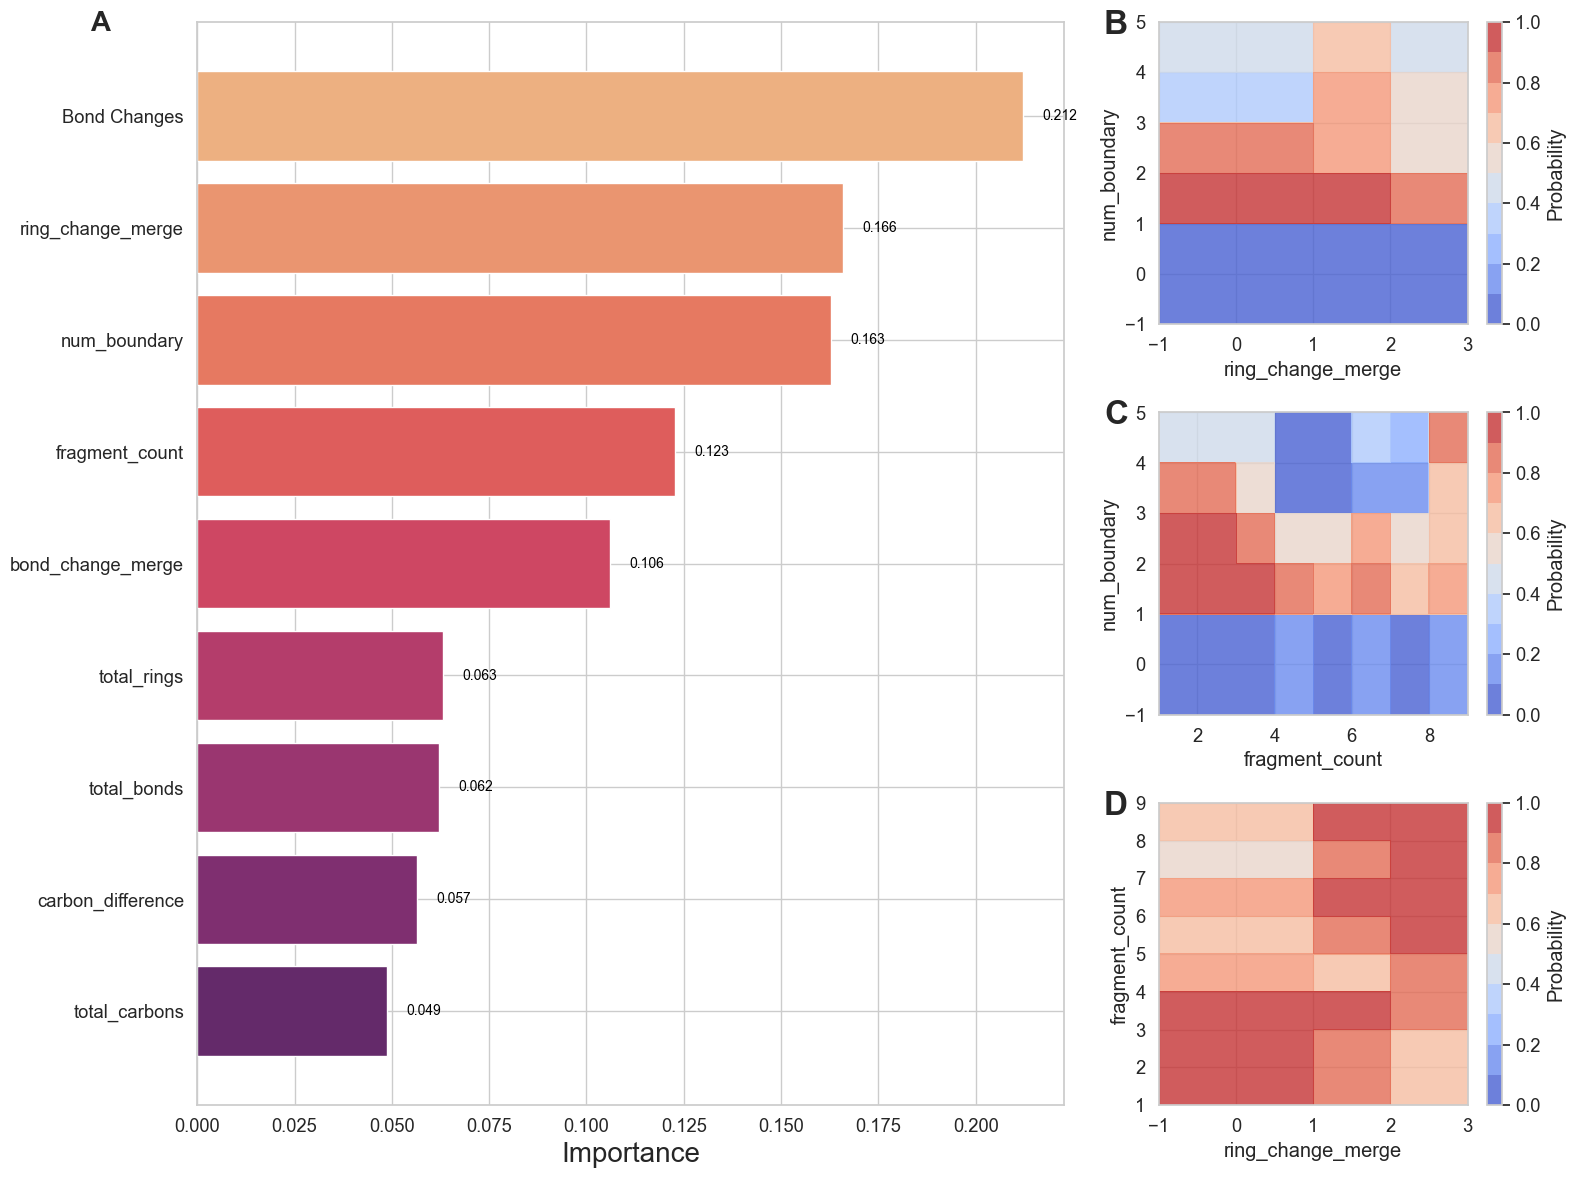

In [222]:
vis = Visualization(data_check, 'Result', [('ring_change_merge','num_boundary'),
                                           ('fragment_count','num_boundary'), 
                                           ('ring_change_merge','fragment_count')])
vis.visualize()

## Train model

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Pipeline

data_raw = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                                            'Index', 'mcs_carbon_balanced'], axis =1)
X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not removing hydrogen atom without neighbors
[21:22:03] WARNING: not r

In [86]:
steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.78        87
           1       0.95      0.94      0.94       364

    accuracy                           0.91       451
   macro avg       0.85      0.87      0.86       451
weighted avg       0.91      0.91      0.91       451



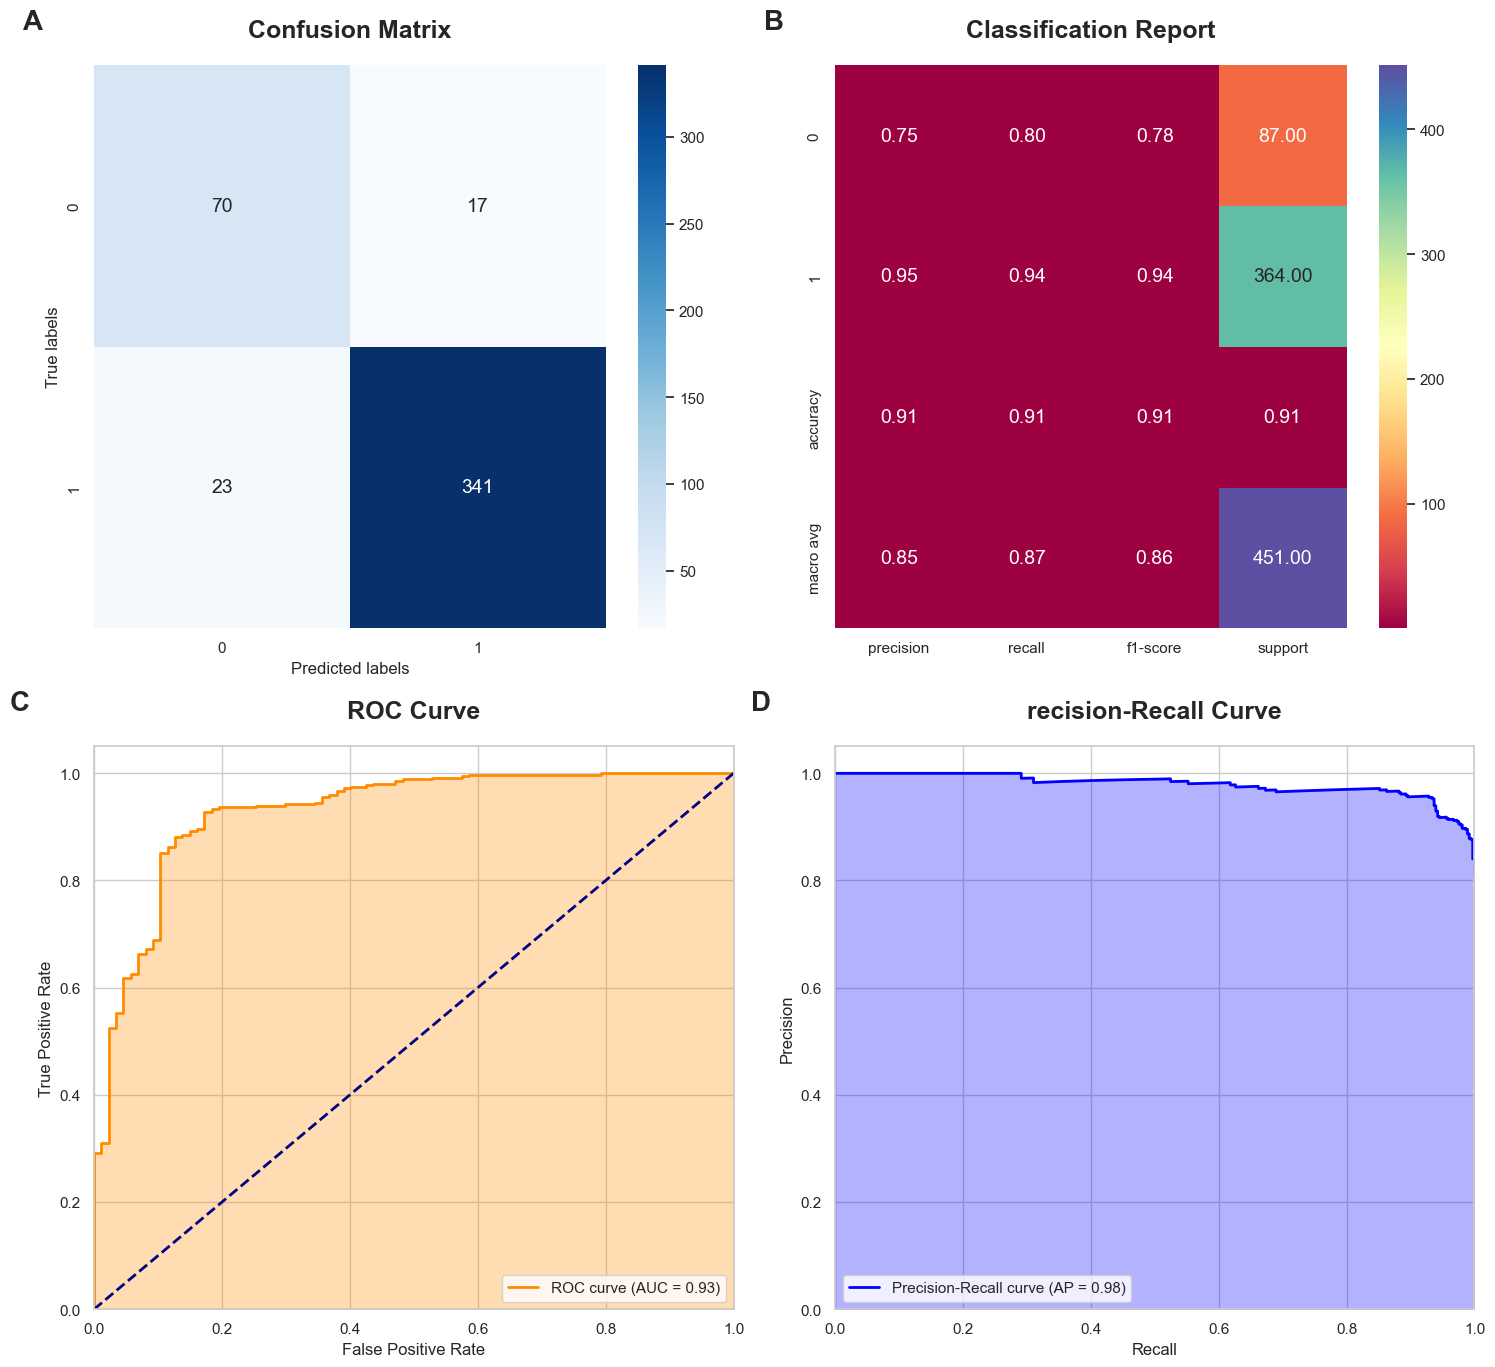

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import pandas as pd

def classification_visualization(y_true, y_pred, y_proba):
    # Setup the matplotlib figure and axes, 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    #fig.suptitle('Advanced Classification Metrics Visualization', fontsize=16)

    labels = ['A', 'B', 'C', 'D']  # Labels for each subplot
    for ax, label in zip(axes.flat, labels):
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, size=20, weight='bold', va='top', ha='right')

    # Subfig 1: Confusion Matrix
    ax = axes[0, 0]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 14})
    ax.set(xlabel='Predicted labels', ylabel='True labels')
    ax.set_title('Confusion Matrix', fontsize=18, weight='bold', pad=20)

    # Subfig 2: Classification Report
    ax = axes[0, 1]
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='Spectral', cbar=True, fmt=".2f", ax=ax, annot_kws={"size": 14})
    ax.set_title('Classification Report', fontsize=18, weight='bold', pad=20)

    # Enhance ROC Curve visual
    ax = axes[1, 0]
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='darkorange', lw=2)
    ax.fill_between(fpr, tpr, color='darkorange', alpha=0.3)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set_title('ROC Curve', fontsize=18, weight='bold', pad=20)

    ax.legend(loc="lower right")

    # Enhance Precision-Recall Curve visual
    ax = axes[1, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    average_precision = average_precision_score(y_true, y_proba)
    ax.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % average_precision, color='blue', lw=2)
    ax.fill_between(recall, precision, color='blue', alpha=0.3)
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='Recall', ylabel='Precision')
    ax.set_title('recision-Recall Curve', fontsize=18, weight='bold', pad=20)

    ax.legend(loc="lower left")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

classification_visualization(y_test, y_pred, pipeline.predict_proba(X_test)[:,1])


# Rule-based

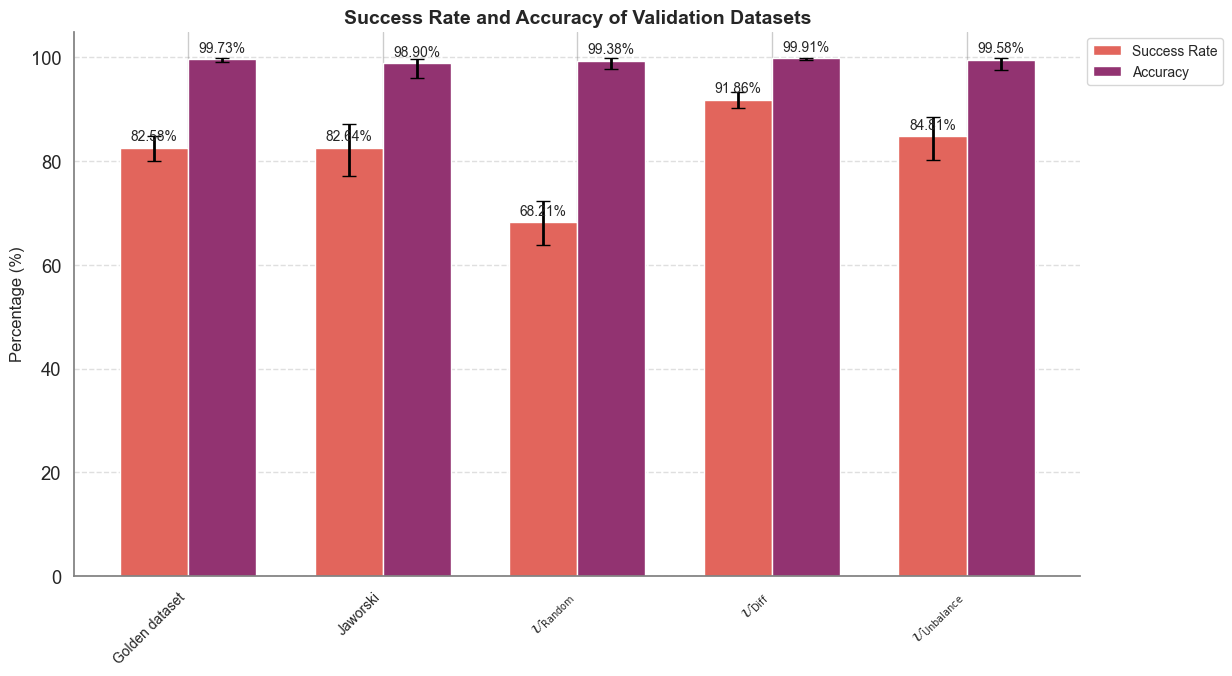

In [225]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Data
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])

# Successes and accuracies
successes = np.round(unbalance * success_rate).astype(int)
accuracies = np.round(successes * accuracy).astype(int)

# Confidence intervals
confint_success = proportion_confint(successes, unbalance, method='wilson')
confint_accuracy = proportion_confint(accuracies, successes, method='wilson')

# Error margins
error_success = np.abs(np.vstack(confint_success) - success_rate)
error_accuracy = np.abs(np.vstack(confint_accuracy) - accuracy)

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)
color_for_accuracy = cmap(0.7)

# Plotting
bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})

# Labels and styling
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

# Annotation function
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

# Legend and layout
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


# analysis MCS

In [ ]:
from SynRBL.SynMCSImputer.SubStructure.mcs_process import ensemble_mcs
from SynRBL.SynUtils.data_utils import load_database, save_database
from SynRBL.SynMCSImputer.SubStructure.extract_common_mcs import ExtractMCS
from SynRBL.SynMCSImputer.MissingGraph.find_graph_dict import find_graph_dict
from SynRBL.SynMCSImputer.MissingGraph.refinement_uncertainty import RefinementUncertainty

mcs1 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_1.json.gz')
mcs2 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_2.json.gz')
mcs3 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_3.json.gz')
mcs4 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_4.json.gz')
mcs5 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_5.json.gz')

In [ ]:
mcs_check_uncertainty('USPTO_unbalance_class')

In [ ]:
data_name = 'golden_dataset'
mcs_dir = f'../../../Data/Validation_set/{data_name}/MCS'
missing_results_largest  = find_graph_dict(msc_dict_path=f'{mcs_dir}/MCS_Largest.json.gz', 
                                            save_path= './test.json.gz')

In [ ]:
datasets = ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble']
golden = [256, 279, 211, 269, 398, 195]
jaworski = [26, 30, 22, 33, 46, 21]
random = [66, 80, 60, 75, 203, 60]
diff = [44, 50, 42, 45, 128, 40]
unbalance = [37, 37, 33, 35, 130, 33]


In [ ]:
# golden
# Uncertainty Data: 256
# STOP HERE Condition_1
# Uncertainty Data: 279
# STOP HERE Condition_2
# Uncertainty Data: 211
# STOP HERE Condition_3
# Uncertainty Data: 269
# STOP HERE Condition_4
# Uncertainty Data: 398
# STOP HERE Condition_5
# Uncertainty Data: 195
# STOP HERE MCS_Largest

# jaworski
# Uncertainty Data: 26
# STOP HERE Condition_1
# Uncertainty Data: 30
# STOP HERE Condition_2
# Uncertainty Data: 22
# STOP HERE Condition_3
# Uncertainty Data: 33
# STOP HERE Condition_4
# Uncertainty Data: 46
# STOP HERE Condition_5
# Uncertainty Data: 21
# STOP HERE MCS_Largest

# random class
#     Uncertainty Data: 66
# STOP HERE Condition_1
# Uncertainty Data: 80
# STOP HERE Condition_2
# Uncertainty Data: 60
# STOP HERE Condition_3
# Uncertainty Data: 75
# STOP HERE Condition_4
# Uncertainty Data: 203
# STOP HERE Condition_5
# Uncertainty Data: 60
# STOP HERE MCS_Largest

# unbalance
# Uncertainty Data: 37
# STOP HERE Condition_1
# Uncertainty Data: 37
# STOP HERE Condition_2
# Uncertainty Data: 33
# STOP HERE Condition_3
# Uncertainty Data: 35
# STOP HERE Condition_4
# Uncertainty Data: 130
# STOP HERE Condition_5
# Uncertainty Data: 33
# STOP HERE MCS_Largest




# diff
# Uncertainty Data: 44
# STOP HERE Condition_1
# Uncertainty Data: 50
# STOP HERE Condition_2
# Uncertainty Data: 42
# STOP HERE Condition_3
# Uncertainty Data: 45
# STOP HERE Condition_4
# Uncertainty Data: 128
# STOP HERE Condition_5
# Uncertainty Data: 40
# STOP HERE MCS_Largest

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Plot
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='Dataset', y='Value', hue='Configuration', data=df, palette=palette)

# Customizing the plot
plt.title('Effect of Ensemble Method in Reducing Uncertainty', fontsize=14)
plt.ylabel('Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar with the value
for p in bar_plot.patches:
    print()
    text = format(p.get_height(), '.0f')
    bar_plot.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.savefig('./benchmark_mcs.pdf', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars
plt.figure(figsize=(10, 6))
plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(10, 6))
bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Configuration in MCS', fontsize=16, weight='semibold')
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                       "RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                       "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                       "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                       "MCES\nMCES",
                       "Ensemble: Largest"],  # Added "Ensemble: Largest" configuration
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('viridis')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i / (num_configs - 1)) for i in range(num_configs - 1)]  # Exclude the last color for "Ensemble: Largest"
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette.append(ensemble_color)  # Add the distinct color to "Ensemble: Largest"

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Create a custom legend
legend_labels = ["RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                 "RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                 "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                 "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                 "MCES\nMCES",
                 "Ensemble: Largest"]  # Added legend label for "Ensemble: Largest"

legend_colors = [palette[i] for i in range(num_configs)]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[i], ec="k", lw=1) for i in range(num_configs)]

plt.legend(legend_handles, legend_labels, title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()
